In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_classifier_1d import train_hdc_classifier, test_hdc_classifier
from laplace_hdc_encoder_1d import hdc_encoder
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")

Using device:	cuda:0


### Hyperparameters

In [2]:
hyperdim = 5000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
epochs=10

## Load Data

In [3]:
def load_ucr(file):
    data = np.loadtxt(file)
    X = data[:, 1:]
    y = data[:, 0]
    y = np.where(y == 1, 1, 0)  # convert labels to 0/1
    return X, y

# Adjust file paths to your local files
X_train, y_train = load_ucr("../FordA_TRAIN.txt")
X_test, y_test = load_ucr("../FordA_TEST.txt")

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ——— Normalization step (min-max per feature) ———
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)

denom = (X_max - X_min)
denom[denom == 0] = 1   # avoid division by zero

X_train_norm = (X_train - X_min) / denom
X_test_norm  = (X_test  - X_min) / denom

# Optional: clip to [0,1] just in case
X_train_norm = np.clip(X_train_norm, 0, 1)
X_test_norm  = np.clip(X_test_norm, 0, 1)

# ——— Prepare tensors & dataloaders ———
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_tensor = torch.tensor(X_train_norm)
x_test_tensor  = torch.tensor(X_test_norm)

train_data = TensorDataset(x_train_tensor, torch.tensor(y_train))
test_data  = TensorDataset(x_test_tensor, torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32)

Train shape: (3601, 500), Test shape: (1320, 500)


## Kernel Matrix Construction

lambda = 0.03653908684643524
500


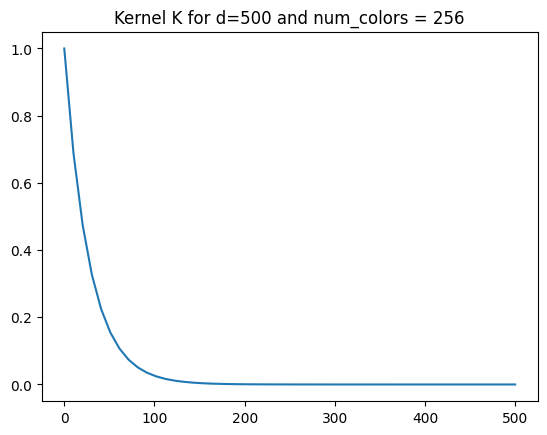

In [4]:
# Determining Lambda from random 1000 samples
batch_size = 1024
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
print(d)
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

## Classification

In [5]:
import torch
from torch.utils.data import TensorDataset
from typing import Optional   # ← add this

@torch.no_grad()
def flip_bits_bool(H: torch.BoolTensor,
                   perc: float,
                   *,
                   inplace: bool = True,
                   ) -> torch.BoolTensor:
    """
    Flip exactly round(perc·D) bits in each row of a boolean tensor H.

    Works on a flattened (M, D) view, then reshapes back to H’s shape.
    """
    if perc <= 0.0:
        return H if inplace else H.clone()

    flat = H.view(H.shape[0], -1)        # (M, D)
    M, D = flat.shape
    k = int(round(perc * D))
    if k == 0:
        return H if inplace else H.clone()

    out = flat if inplace else flat.clone()
    rows = torch.arange(M, device=H.device).repeat_interleave(k)

    cols = torch.cat([
        torch.multinomial(torch.ones(D, device=H.device),
                          k, replacement=False)
        for _ in range(M)
    ])

    out[rows, cols] = ~out[rows, cols]   # toggle bits (True ↔ False)
    return out.view_as(H)



def corrupt_dataset(dataset: TensorDataset, perc: float):
    """
    Return a new TensorDataset whose data tensor has been bit-flipped.
    Labels are untouched.
    """
    data, labels = dataset.tensors
    data_flipped = flip_bits_bool(data.clone(), perc)
    return TensorDataset(data_flipped, labels)


In [6]:
num_workers = 2
pin_memory=True
n_splits = 20
split_size = 500
flip_percs = np.arange(0.0, 0.51, 0.05)
accuracies = np.zeros((len(flip_percs), n_splits))
num_classes=2
nHDC = 15_000
for i, perc in enumerate(flip_percs):
    print(f'Hyperdimension: {nHDC} Started --------------')
    # Train
    encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
    train_hdc = encoder.encode(train_loader)
    train_loader_hdc = DataLoader(
        train_hdc,
        batch_size=10,
        shuffle=True,
        num_workers=0,      # <-- no background workers
        pin_memory=False    # <-- nothing to pin; data is on GPU
    )
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
    print(f'Encoding Train Data and Training the Model for Flipping Percentage={np.round(perc, 2)} finished')
    for split_idx in tqdm(range(n_splits)):
        # Test
        np.random.seed(split_idx)
        split_indices = np.random.choice(len(test_data), size=split_size, replace=False)
        split_subset = Subset(test_data, split_indices)
        split_loader = DataLoader(
            split_subset,
            batch_size=10,
            shuffle=False,
            num_workers=num_workers,   # 2, as you set above
            pin_memory=pin_memory      # True
        )
        split_hdc = encoder.encode(split_loader)
        split_hdc = corrupt_dataset(split_hdc, perc=perc)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=10,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)
    print(f'Flipping Percentage: {np.round(perc, 2)} Finished. Average Accuracy over 20 splits: {np.mean(accuracies[i])}')


Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.0 finished


100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


Flipping Percentage: 0.0 Finished. Average Accuracy over 20 splits: 0.6364
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.05 finished


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


Flipping Percentage: 0.05 Finished. Average Accuracy over 20 splits: 0.6379
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.1 finished


100%|██████████| 20/20 [01:05<00:00,  3.27s/it]


Flipping Percentage: 0.1 Finished. Average Accuracy over 20 splits: 0.6139
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.15 finished


100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


Flipping Percentage: 0.15 Finished. Average Accuracy over 20 splits: 0.6255999999999999
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.2 finished


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


Flipping Percentage: 0.2 Finished. Average Accuracy over 20 splits: 0.5818
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.25 finished


100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


Flipping Percentage: 0.25 Finished. Average Accuracy over 20 splits: 0.6068
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.3 finished


100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


Flipping Percentage: 0.3 Finished. Average Accuracy over 20 splits: 0.5824
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.35 finished


100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


Flipping Percentage: 0.35 Finished. Average Accuracy over 20 splits: 0.5717999999999999
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.4 finished


100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


Flipping Percentage: 0.4 Finished. Average Accuracy over 20 splits: 0.5363999999999999
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.45 finished


100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Flipping Percentage: 0.45 Finished. Average Accuracy over 20 splits: 0.5293000000000001
Hyperdimension: 15000 Started --------------
Encoding Train Data and Training the Model for Flipping Percentage=0.5 finished


100%|██████████| 20/20 [01:14<00:00,  3.71s/it]

Flipping Percentage: 0.5 Finished. Average Accuracy over 20 splits: 0.5087999999999999


In [7]:
accuracies

array([[0.608, 0.658, 0.636, 0.682, 0.624, 0.636, 0.6  , 0.628, 0.644,
        0.638, 0.62 , 0.64 , 0.646, 0.642, 0.64 , 0.65 , 0.608, 0.652,
        0.636, 0.64 ],
       [0.624, 0.65 , 0.616, 0.66 , 0.634, 0.642, 0.642, 0.618, 0.64 ,
        0.662, 0.654, 0.608, 0.672, 0.64 , 0.62 , 0.618, 0.644, 0.636,
        0.634, 0.644],
       [0.572, 0.596, 0.61 , 0.63 , 0.602, 0.642, 0.626, 0.602, 0.626,
        0.586, 0.602, 0.61 , 0.644, 0.608, 0.612, 0.626, 0.604, 0.622,
        0.64 , 0.618],
       [0.622, 0.65 , 0.62 , 0.632, 0.608, 0.614, 0.602, 0.596, 0.622,
        0.618, 0.594, 0.58 , 0.648, 0.648, 0.62 , 0.646, 0.61 , 0.676,
        0.664, 0.642],
       [0.58 , 0.628, 0.58 , 0.606, 0.594, 0.572, 0.618, 0.544, 0.582,
        0.588, 0.542, 0.578, 0.56 , 0.572, 0.528, 0.582, 0.6  , 0.604,
        0.604, 0.574],
       [0.612, 0.658, 0.628, 0.592, 0.616, 0.582, 0.592, 0.614, 0.616,
        0.58 , 0.632, 0.59 , 0.626, 0.604, 0.6  , 0.596, 0.586, 0.596,
        0.62 , 0.596],
       [0.

In [8]:
savemat('FordA_LaplaceHDC.mat', {'FordA_LaplaceHDC': accuracies*100})